In [2]:
import sys
sys.path.insert(0, '../shared/')

import random
import numpy as np
import pandas as pd
import seqlogo as sl
from data_readers import *
from seq_ops import get_seq, reverse_complement

from collections import Counter

In [2]:
# Used for converting bases to index positions
def base2idx(alphabet_type = 'DNA', alphabet = None):
    # Dynamically allows for alternative alphabets
    if alphabet is None:
        if alphabet_type in sl.utils._IDX_LETTERS:
            alphabet = sl.utils._IDX_LETTERS[alphabet_type]
    else:
        alphabet = alphabet
    return {base: i for i, base in enumerate(alphabet)}[letter]

In [2]:
def build_pfm(sequences, alphabet_type = 'DNA', alphabet = None):
    """Generate a Position Frequency Matrix (PFM) from a series of FASTA sequences

    Args:
        sequences (list of str): The desired sequences to build the PFM from
        alphabet_type (str): Desired alphabet to use. Order matters (default: 'DNA')
                            "DNA" := "ACGT"
                            "reduced DNA" := "ACGTN-"
                            "ambig DNA" := "ACGTRYSWKMBDHVN-"
                            "RNA" := "ACGU"
                            "reduced RNA" := "ACGUN-"
                            "ambig RNA" := "ACGURYSWKMBDHVN-"
                            "AA" : = "ACDEFGHIKLMNPQRSTVWY"
                            "reduced AA" := "ACDEFGHIKLMNPQRSTVWYX*-"
                            "ambig AA" := "ACDEFGHIKLMNOPQRSTUVWYBJZX*-"
        alphabet (str): if 'custom' is selected or a specialize alphabet is desired, 
                        this accepts a string (default: None)
    Returns:
        pfm (np.array): Position frequency matrix from given sequences
    """
    # Dynamically allows for alternative alphabets
    if alphabet is None:
        if alphabet_type in sl.utils._IDX_LETTERS:
            fresh_alphabet = sl.utils._IDX_LETTERS[alphabet_type]
    else:
        fresh_alphabet = alphabet
    
    # Initialize an empty numpy array
    pfm = np.zeros((len(sequences[0]), len(fresh_alphabet)), dtype=int)

    # Add base-wise counts to the numpy array to build PFM matrix
    for seq in sequences:

        # For each sequence we count which bases we see at each position
        for pos, base in enumerate(seq):
            pfm[pos, base2idx[base]] += 1
    
    return pfm

In [2]:
def build_pwm(pfm, pseudocount = 0.25, background = 0.25):
    """Function to build a PWM from a PFM

    Args:
        pfm (np.array): dimensions are seqLength by alphabetLength

    Returns:
        pwm (np.array): dimensions are seqLength by alphabetLength
    """ 
    # Calculate the sums of each 
    sums = np.sum(pfm, axis = 1).reshape((pfm.shape[0], 1))
    
    # For simplicity, pseudocounts and background are set to .25
    p = pseudocount
    bg = background
    
    # For each position in the matrix, apply the PWM formula
    pwm = np.log2((pfm + p) / (sums + p * pfm.shape[1])) - np.log2(bg)
    
    # Return pwm
    return pwm

In [2]:
def score_kmer(seq, pwm, alphabet_type, alphabet):
    """Function to score a kmer with a pwm
        kmer length is expected to be the same as pwm length

    Args:
        seq(str): kmer to score
        pwm (numpy array): pwm for scoring

    Returns:
        score (float): PWM score for kmer
    """
    # Initialize score to 0
    score = 0
    if len(seq) != pwm.shape[0]:
        raise ValueError('K-mer and PWM are different lengths!')
    
    # Iterate across kmer and sum log likelihoods
    for j, base in enumerate(seq):
        score += pwm[j, base2idx[base]]

    # Return score
    return score


## More concise version of score_kmer but less performant
# def score_kmer(seq, pwm):
#     """Function to score a kmer with a pwm

#     Args:
#         seq(str): kmer to score
#         pwm (seqlogo.Pwm): pwm for scoring

#     Returns:
#         score (float): PWM score for kmer

#     Raises:
#         AssertionError: if sequence length is not equal to PWM length
#     """
#     assert len(seq) == pwm.shape[0], 'K-mer and PWM are different lengths'
#     return np.sum(pwm.lookup(pwm.index, list(seq)))

In [2]:
def get_background(bg_seqs, alphabet_type = 'DNA', alphabet = None):
    """Quickly count the background base counts

    Args:
        bg_seqs (list of str): The flanking sequences around the motifs
        alphabet_type (str): Desired alphabet to use. Order matters (default: 'DNA')
                            "DNA" := "ACGT"
                            "reduced DNA" := "ACGTN-"
                            "ambig DNA" := "ACGTRYSWKMBDHVN-"
                            "RNA" := "ACGU"
                            "reduced RNA" := "ACGUN-"
                            "ambig RNA" := "ACGURYSWKMBDHVN-"
                            "AA" : = "ACDEFGHIKLMNPQRSTVWY"
                            "reduced AA" := "ACDEFGHIKLMNPQRSTVWYX*-"
                            "ambig AA" := "ACDEFGHIKLMNOPQRSTUVWYBJZX*-"
        alphabet (str): if 'custom' is selected or a specialize alphabet is desired, 
                        this accepts a string (default: None)

    Returns:
        bg_counts (list of floats): frequencies of each base within the bg_seqs
    """
    # Initialize the values if on the first loop
    if alphabet is None:
        if alphabet_type in sl.utils._IDX_LETTERS:
            bg_alphabet = sl.utils._IDX_LETTERS[alphabet_type]
    else:
        bg_alphabet = alphabet
    bg = ''.join(bg_seqs).upper()
    bg_counts = []
    for letter in bg_alphabet:
        bg_counts.append(bg.count(letter)/len(bg))
        
    return bg_counts
    

In [2]:
def init_gibbs(sequences, k = 50):
    """Initialize the Gibbs sampling matrix

    Args:
        sequences (iterable): All the sequences selected for Gibbs sampling
        k (int): size of the desired motif (default: 50)

    Returns:
        motifs (list): A list of randomly selected motifs
        background (pd.Series): the intialized background frequencies
    """
    motifs = []
    bgs = []
    
    for seq in sequences:
        # Control for soft masking
        seq = seq.upper()

        # Start at a random position within the sequence
        idx = random.randint(0, len(seq) - k + 1)
        sub_seq = seq[idx: idx + k]
        bg_seq = seq.replace(sub_seq, '')

        # Positive strand
        if not random.choice([0,1]):
            motifs.append(sub_seq)
            bgs.append(bg_seq)

        # Negative strand
        else:
            motifs.append(reverse_complement(sub_seq))
            bgs.append(reverse_complement(bg_seq))

    # Compute the background frequencies
    return motifs, bgs

In [2]:
def gen_scores(sequence, k, pwm, alphabet_type = 'DNA', alphabet = None):
    """Generate the k-mers scores along the given sequence for both strands

    Calculates both the forward and reverse scores of the given sequence against all possible kmers
    
    Args:
        sequence (str): Hold out sequence from Gibbs Sampling
        k (int): desired size of kmer
        pwm (seqlogo.Pwm): Position weight matrix computed from sampled motifs
        alphabet_type (str): Desired alphabet to use. Order matters (default: 'DNA')
                            "DNA" := "ACGT"
                            "reduced DNA" := "ACGTN-"
                            "ambig DNA" := "ACGTRYSWKMBDHVN-"
                            "RNA" := "ACGU"
                            "reduced RNA" := "ACGUN-"
                            "ambig RNA" := "ACGURYSWKMBDHVN-"
                            "AA" : = "ACDEFGHIKLMNPQRSTVWY"
                            "reduced AA" := "ACDEFGHIKLMNPQRSTVWYX*-"
                            "ambig AA" := "ACDEFGHIKLMNOPQRSTUVWYBJZX*-"
        alphabet (str): if 'custom' is selected or a specialize alphabet is desired, 
                        this accepts a string (default: None)

    Returns:
        scores (pandas.DataFrame): position, strand, score, and normalized score for each kmer
    """
    scores = []
    for pos, base in enumerate(sequence):
        rand_seq_kmer = sequence[pos: pos + k]
        if len(rand_seq_kmer) != k:
            break
        score_pos = score_kmer(rand_seq_kmer, pwm, alphabet_type, alphabet)
        scores.append([pos, 0, score_pos])
        score_neg = score_kmer(reverse_complement(rand_seq_kmer), pwm, alphabet_type, alphabet)
        scores.append([pos, 1, score_neg])
    return scores

In [2]:
def prob_selection(sequence, k, pwm, alphabet_type = 'DNA', alphabet = None):
    """Probablistic selection of new motif

    Calculates both the forward and reverse scores of the given sequence against all possible kmers
    
    Args:
        sequence (str): Hold out sequence from Gibbs Sampling
        k (int): desired size of kmer
        pwm (seqlogo.Pwm): Position weight matrix computed from sampled motifs
        alphabet_type (str): Desired alphabet to use. Order matters (default: 'DNA')
                            "DNA" := "ACGT"
                            "reduced DNA" := "ACGTN-"
                            "ambig DNA" := "ACGTRYSWKMBDHVN-"
                            "RNA" := "ACGU"
                            "reduced RNA" := "ACGUN-"
                            "ambig RNA" := "ACGURYSWKMBDHVN-"
                            "AA" : = "ACDEFGHIKLMNPQRSTVWY"
                            "reduced AA" := "ACDEFGHIKLMNPQRSTVWYX*-"
                            "ambig AA" := "ACDEFGHIKLMNOPQRSTUVWYBJZX*-"
        alphabet (str): if 'custom' is selected or a specialize alphabet is desired, 
                        this accepts a string (default: None)

    Returns:
        idx (int): Probabilistically-selected starting index position of the new motif
        strand (bool): either forward (False) or backward (True) strand
    """
    scores = gen_scores(sequence, k, pwm)
    
    # Convert scores to probabilities
    scores = pd.DataFrame(scores, columns=['pos', 'strand', 'score'])
    exp_score = np.exp2(scores.score)
    scores['scores_norm'] = exp_score / np.sum(exp_score)

    # Get the new index and strand
    idx, strand = scores.sample(n = 1, weights = 'scores_norm').iloc[0,:2].astype(int).tolist()

    return idx, strand

In [2]:
def gibbs_motif_finder(sequences, k = 50, epochs = 10000, tolerance = 1e-5, 
                        background = None, compute_background = False, pseudocount = 0.25,
                        alphabet_type = 'DNA', alphabet = None):
    """Attempts to identify the optimum motif for given sequences probabilistically

    Args:
        sequences (list): List of all promoter sequences that contain the pattern of interest
        k (int): Desired size of kmers (default: 50)
        epochs (int): Number of iterations before convergence detection is abandoned (default: 1000)
        tolerance (float): Measure of how close two IC scores should be to detect convergence (default: 1e-4)
        background (const or iterable): Background frequencies for sequence alphabet (default: None)
        compute_background (bool): whether or not to attempt to compute background frequencies (default: False)
        alphabet_type (str): Desired alphabet to use. Order matters (default: 'DNA')
                            "DNA" := "ACGT"
                            "reduced DNA" := "ACGTN-"
                            "ambig DNA" := "ACGTRYSWKMBDHVN-"
                            "RNA" := "ACGU"
                            "reduced RNA" := "ACGUN-"
                            "ambig RNA" := "ACGURYSWKMBDHVN-"
                            "AA" : = "ACDEFGHIKLMNPQRSTVWY"
                            "reduced AA" := "ACDEFGHIKLMNPQRSTVWYX*-"
                            "ambig AA" := "ACDEFGHIKLMNOPQRSTUVWYBJZX*-"
        alphabet (str): if 'custom' is selected or a specialize alphabet is desired, 
                        this accepts a string (default: None)

    Returns:
        gibbs_pfm (np.array): the final PFM using the held-out motifs
        final_cpm (seqlogo.Cpm): the final CPM using all the motifs 
    """
    # Dynamically create base2index based on current alphabet
    global base2idx
    base2idx = gen_base2idx(alphabet_type, alphabet)
    
    motifs, bg = init_gibbs(sequences, k)
    
    # Initialize the background
    if compute_background:
        background = get_background(bg)
    elif background is None:
        background = 0.25
    else:
        background = background

    # Used for tracking convergence
    last_ic = None

    for i in range(0, epochs + 1):
        # Check for convergence
        if i % 100 == 0:
            conv_cpm = sl.Cpm(pfm = build_pfm(motifs, alphabet_type, alphabet), background = background)
            curr_ic = np.sum(conv_cpm.ic)
            print(f'Current IC score @ {i} epochs: {curr_ic}')

            if last_ic is None:
                last_ic = curr_ic
            else:
                # Exit of convergence is detected
                if np.isclose(curr_ic, last_ic, rtol = tolerance):
                    print(f'Convergence detected (± {tolerance})')
                    return pfm, conv_cpm

                # Or update and continue
                else:
                    last_ic = curr_ic

        # Temporarily copy the sequences/motifs to prevent overwriting originals
        mod_seqs = sequences[:]
        mod_motifs = motifs[:]

        # Remove and hold out one random sequence
        rand_idx = random.randrange(len(mod_seqs))
        rand_seq = mod_seqs.pop(rand_idx)

        # "Throw away" selected motif
        _ = mod_motifs.pop(rand_idx)

        # Build a seqlogo.Cpm from modified sequence list
        pfm = build_pfm(mod_motifs, alphabet_type, alphabet)
        pwm = build_pwm(pfm, pseudocount = pseudocount, background = background)

        # Probablistic selection of updated motif index
        index_new, strand_new = prob_selection(rand_seq, k, pwm, alphabet_type, alphabet)

        # Control for strandedness and update
        new_motif = rand_seq[index_new: index_new + k]
        # Positive Strand
        if not strand_new:
            motifs[rand_idx] = new_motif
            
            # In case the user wants to compute the background
            if compute_background:
                bg[rand_idx] = sequences[rand_idx].replace(new_motif, '')
                background = get_background(bg)
            
        # Negative Strand
        else:
            motifs[rand_idx] = reverse_complement(new_motif)
            
            # In case the user wants to compute the background
            if compute_background:
                bg[rand_idx] = reverse_complement(sequences[rand_idx]).replace(reverse_complement(new_motif), '')
                background = get_background(bg)
                
    # If epochs is maxed out
    print(f'Exited after {i} epochs')
    print(f'No convergence detected within tolerance: {tolerance}')
    final_cpm = sl.Cpm(pfm = build_pfm(motifs, alphabet_type, alphabet), alphabet_type = alphabet_type, alphabet = alphabet, pseudocount = pseudocount, background = background)
    print(f'Final IC score: {np.sum(final_cpm.ic)}')
    return pfm, final_cpm

In [3]:
def get_promoters(fasta_file, gtf_file, size = 50, pattern = "AGGAGG"):
    """Get all promoter sequences that contain a specific pattern

    Args:
        fasta_file (str): /path/to/file.fa
        gtf_file (str): /path/to/file.gff[.gz]
        size (int): Size of upstream sequence desired
        pattern (str): pattern/sequence of interest

    Returns:
        seqs (list): List of all promoter sequences that contain the pattern of interest
    """
    seqs = []
    for name, seq in get_fasta(seq_file):
        for gff_entry in get_gff(gff_file):
            if gff_entry.type == 'CDS':
                promoter_seq = get_seq(seq, gff_entry.start, gff_entry.end, gff_entry.strand, size) 
                if "AGGAGG" in promoter_seq:
                    seqs.append(promoter_seq)
    else:
        return seqs

In [5]:
seq_file="../class_3/data/GCF_000009045.1_ASM904v1_genomic.fna.gz"
gff_file="../class_3/data/GCF_000009045.1_ASM904v1_genomic.gff.gz"

In [6]:
seqs = get_promoters(seq_file, gff_file)

In [7]:
gibbs_pfm, final = gibbs_motif_finder(seqs, 10, epochs = 10000, compute_background=True)

Current IC score @ 0 epochs: 0.013045814609975925
Current IC score @ 100 epochs: 0.024016590420507862
Current IC score @ 200 epochs: 0.031588822303752095
Current IC score @ 300 epochs: 0.04520090350197234
Current IC score @ 400 epochs: 0.06771646617796961
Current IC score @ 500 epochs: 0.07798852527446176
Current IC score @ 600 epochs: 0.09276317871632372
Current IC score @ 700 epochs: 0.11154572030443557
Current IC score @ 800 epochs: 0.13464572528366664
Current IC score @ 900 epochs: 0.15529080889871927
Current IC score @ 1000 epochs: 0.17145390634107083
Current IC score @ 1100 epochs: 0.1734934701028662
Current IC score @ 1200 epochs: 0.2250887454975977
Current IC score @ 1300 epochs: 0.26502495053973213
Current IC score @ 1400 epochs: 0.3497388471283836
Current IC score @ 1500 epochs: 0.4241996534026293
Current IC score @ 1600 epochs: 0.4637943510451151
Current IC score @ 1700 epochs: 0.5573680969145023
Current IC score @ 1800 epochs: 0.6420462153585538
Current IC score @ 1900 epoc

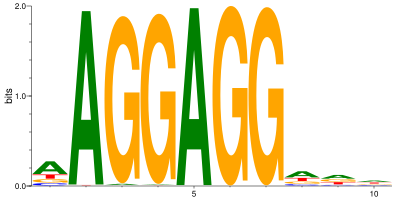

In [8]:
sl.seqlogo(sl.Cpm(pfm= gibbs_pfm))